# Проект по А/B-тестированию  
  
**Цели исследования:**
- проанализировать результат проведения А/В-теста `recommender_system_test`
- оценить влияние на пользовательские метрики в результате А/В-тестирования:  
  * конверсия в просмотры товара
  * конверсия в переход в корзину товаров
  * конверсия в покупки  
  
**Этапы проведения исследования:**
- Обзор данных, первоначальная оценка
- Оценка аудитории проведения теста
- Соответствие данных требованиям технического задания.
- Соотнесение времени проведения теста с маркетинговыми акциями
- Оценка кол-ва событий в группах теста
- Построение воронки продаж по группам теста
- Проверка статистической разницы долей наступления собитий по группам теста z-критерием.
- Выводы о корректности и результатах проведения теста

## Обзор данных

In [2]:
import pandas as pd
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import datetime as dt
from datetime import timedelta
import math as mth
import cmath as cmth

In [3]:
try:
  marketing_events = pd.read_csv('/content/ab_project_marketing_events.csv')
  ab_events = pd.read_csv('/content/final_ab_events.csv')
  ab_new_users = pd.read_csv('/content/final_ab_new_users.csv')
  ab_participants = pd.read_csv('/content/final_ab_participants.csv')
except:
  marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
  ab_events = pd.read_csv('/datasets/final_ab_events.csv')
  ab_new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
  ab_participants = pd.read_csv('/datasets/final_ab_participants.csv')


In [4]:
marketing_events.info()
marketing_events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [5]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

In [6]:
ab_events.info()
ab_events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


В колонке `details` присутствуют данные о сумме покупки, если она осуществлена, в остальных случаях данные отсутствуют.

In [7]:
ab_events['event_dt'] = pd.to_datetime(ab_events['event_dt'])

In [8]:
ab_new_users.info()
ab_new_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [9]:
ab_new_users['first_date'] = pd.to_datetime(ab_new_users['first_date'])

In [10]:
ab_participants.info()
ab_participants.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


### Проверим таблицы на наличие дубликатов

In [11]:
marketing_events[marketing_events.duplicated()]

,name,regions,start_dt,finish_dt


In [12]:
ab_events[ab_events.duplicated()]

,user_id,event_dt,event_name,details


In [13]:
ab_new_users[ab_new_users.duplicated()]

,user_id,first_date,region,device


In [14]:
ab_participants[ab_participants.duplicated()]

,user_id,group,ab_test


**Вывод:** дубликатов нет

## Оценка аудитории проведения теста

Посмтрим на данные в датасете ab_participants

In [15]:
ab_participants.groupby(['ab_test','group'])['user_id'].count()

ab_test                  group
interface_eu_test        A        5831
                         B        5736
recommender_system_test  A        3824
                         B        2877
Name: user_id, dtype: int64

Выделим в отдельный датасет пользователей из нужного нам теста `recommender_system_test`, оценим их кол-во - по тех.заданию нам необходимо 6000 пользователей

In [16]:
test_ab_rst = ab_participants.query('ab_test == "recommender_system_test"')
test_ab_rst.user_id.nunique()

6701

Проверим пересечение пользователей в группах А и В теста `recommender_system_test`, оценим их кол-во

In [17]:
users_rst_ab = test_ab_rst.groupby('user_id').agg({'group':'nunique'}).query('group > 1')
len(users_rst_ab)

0

Пересекающихся пользователей нет

Выделим в отдельный датасет пользователей из конкурирующего теста `interface_eu_test`

In [18]:
test_ab_iet = ab_participants.query('ab_test == "interface_eu_test"')

In [19]:
print('Пользователи группы A конкурирующего теста interface_eu_test, попавшие в тест recommender_system_test:')
print('Кол-во:',test_ab_iet.query('user_id in @test_ab_rst.user_id and group == "A"')['user_id'].nunique())
print('Процент от общего кол-ва:',(test_ab_iet.query('user_id in @test_ab_rst.user_id and group == "A"')['user_id'].nunique()/
                                   test_ab_rst.user_id.nunique()*100),'%')

Пользователи группы A конкурирующего теста interface_eu_test, попавшие в тест recommender_system_test:
Кол-во: 819
Процент от общего кол-ва: 12.22205640949112 %


In [20]:
print('Пользователи контрольной группы B конкурирующего теста interface_eu_test, попавшие в тест recommender_system_test:')
print('Кол-во:', test_ab_iet.query('user_id in @test_ab_rst.user_id and group == "B"')['user_id'].nunique())
print('Процент от общего кол-ва:',((test_ab_iet.query('user_id in @test_ab_rst.user_id and group == "B"')['user_id'].nunique()/
                                    test_ab_rst.user_id.nunique())*100),'%')

Пользователи контрольной группы B конкурирующего теста interface_eu_test, попавшие в тест recommender_system_test:
Кол-во: 783
Процент от общего кол-ва: 11.68482316072228 %


Посмотрим распределение по группам А и В нашего теста пользователей из гр.В конкурирующего теста

In [21]:
users_in_b_competition = test_ab_iet.query('user_id in @test_ab_rst.user_id and group == "B"')['user_id']
test_ab_rst.query('user_id in @users_in_b_competition').groupby('group')['group'].count()


group
A    439
B    344
Name: group, dtype: int64

**Вывод:**  
- Оставим пользователей группы А конкурирующего теста в нашем тесте `recommender_system_test`, т.к. на них не было какого-либо воздействия
- Для повышения качества анализа теста `recommender_system_test` принимаем решение удалить пользователей экспериментальной группы В теста `interface_eu_test` из нашего теста

In [22]:
test_ab_rst = test_ab_rst.query('user_id not in @users_in_b_competition')

## Проверим данные на соответствие техническому заданию

### Проверим кол-во пользователей, оставшихся после удаления пересечений с конкурирующим тестом

In [23]:
test_ab_rst.user_id.nunique()

5918

In [24]:
(test_ab_rst.user_id.nunique()/6000-1)*100

-1.3666666666666716

**Вывод:** по тех.заданию нам требовалось 6000 пользователей, у нас осталось 5918 чел. - это на 1.4 % меньше, чем требовалось. Поскольку пересекающиеся пользователи могли исказить результаты исследования, исключение их влияния было необходимо.

### Проверим даты набора новых пользователей в тест: объединим данные о регистрации с данными о пользователях в группах

In [25]:
test_ab_rst = test_ab_rst.merge(ab_new_users, on = 'user_id')

### Проверим соответствие дат набора пользователей в тест техническому заданию:  
- запуск теста: 2020-12-07
- окончание набора новых пользователей: 2020-12-21

In [26]:
test_ab_rst['first_date'].min()

Timestamp('2020-12-07 00:00:00')

In [27]:
test_ab_rst['first_date'].max()

Timestamp('2020-12-21 00:00:00')

**Вывод:** даты начала, окончания набора пользователей в тест соответствуют тех.заданию

### Проверим распределение пользователей по группам теста

In [28]:
groups = test_ab_rst.groupby('group')['group'].count()
groups

group
A    3385
B    2533
Name: group, dtype: int64

In [29]:
f'Группа А больше группы В на {((groups[0]/groups[1]-1)*100):.0f} %'

'Группа А больше группы В на 34 %'

В контрольной группе А пользователей больше на 34%, чем в экспериментальной группе В - распределение неравномерное, но не критично, т.к. выборки достаточны по объему.

### Проверим, какой процент пользователей в тесте приходится на Европу - регион EU

In [30]:
(test_ab_rst.query('region == "EU"')['user_id'].count()/len(ab_new_users.\
            query('region == "EU" and "2020-12-21" >= first_date >= "2020-12-07"'))*100).round()

13.0

**Вывод:** на аудиторию теста из Европы приходится 13% отобранных пользователей, т.е. меньше 15%, что не соответствует тех.заданию.

## Объединение датасетов

Объединим датасет с данными пользователей из А/В-теста с данными о действиях пользователей

In [31]:
data_rst = test_ab_rst.merge(ab_events, on = 'user_id', how='left')

In [32]:
data_rst.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24516 entries, 0 to 24515
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     24516 non-null  object        
 1   group       24516 non-null  object        
 2   ab_test     24516 non-null  object        
 3   first_date  24516 non-null  datetime64[ns]
 4   region      24516 non-null  object        
 5   device      24516 non-null  object        
 6   event_dt    21842 non-null  datetime64[ns]
 7   event_name  21842 non-null  object        
 8   details     2939 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 1.9+ MB


Добавим день, на который пользователь совершает событие от даты регистрации

In [33]:
data_rst['event_date'] = pd.to_datetime(data_rst['event_dt'].dt.date)

In [34]:
data_rst['day_event'] = (pd.to_datetime(data_rst['event_date']) - data_rst['first_date'])/ np.timedelta64 ( 1 , 'D')

Посмотрим, какая самая поздняя дата совершения события

In [35]:
data_rst['event_date'].max()

Timestamp('2020-12-30 00:00:00')

**Вывод:** по тех.заданию дата остановки: 2021-01-04, пользователи из теста совершают последнее событие 2020-12-30, т.е. раньше даты остановки, что не соответствует тех.заданию.  
Предположительно, это связано с тем, что сотрудники, проводившие тест, ушли на новогодние каникулы.

## Исследовательский анализ данных

### Посмотрим на кол-во пользователей, которые зарегистрировались, но не совершали событий

Построим график по этим пользователям, не дошедших до воронки продаж, в разбивке по группам, по дням

In [36]:
users_not_event = data_rst.groupby('group')['user_id'].nunique().reset_index().\
      merge(data_rst[data_rst['event_dt'].isna()].groupby('group')['user_id'].nunique().reset_index(), on = 'group')
users_not_event['users_%'] = (users_not_event['user_id_y']/users_not_event['user_id_x']*100).round()
users_not_event

,group,user_id_x,user_id_y,users_%
0,A,3385,963,28.0
1,B,2533,1711,68.0


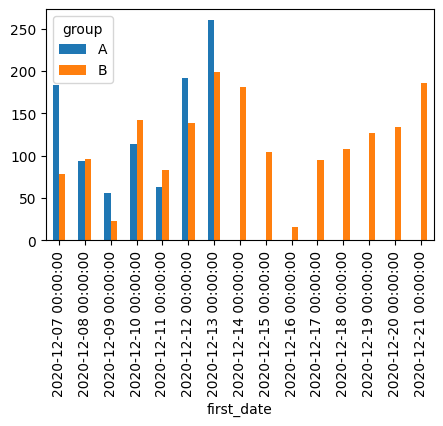

In [37]:
data_rst[data_rst['event_dt'].isna()].pivot_table(index = 'first_date', columns = 'group', values = 'user_id', aggfunc = 'count').\
    plot(kind = 'bar', figsize = (5,3));

**Вывод:** разница между процентами пользователей, не попавшими в воронку продаж существенно различается в группах:
- в группе А - 28% (963 чел.)
- в группе B - 68% (1711 чел.)  
  
Из группы А не попадали в воронку пользователи, набранные с 07.12.2020 по 13.12.2020;  
из группы В не попали в воронку пользователи из всего периода набора с 07.12.2020 по 21.12.2020

### Посмотрим, какие маркетинговые события совпали с временем проведения А\В теста

In [38]:
marketing_events.query('@data_rst.event_date.max()>= start_dt >= @data_rst.first_date.min() or \
                @data_rst.event_date.max()>= finish_dt >= @data_rst.first_date.min()')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


**Вывод:**  
Маркетинговое событие "Christmas&New Year Promo" могло повлиять на пользователей из Европы - даты проведения с 2020-12-25 по	2021-01-03. Необходимо это учесть при дальнейшем анализе.

### Оценим кол-во событий на пользователя внутри выборок

In [39]:
data_rst.groupby(['group','user_id'])['event_date'].count().reset_index()
fig = px.histogram(data_rst.groupby(['group','user_id'])['event_date'].count().reset_index(), x= 'event_date',\
                   color = 'group',width=600, height=500, title = 'Кол-во пользователей по количеству осуществляемых событий')
fig.show()

Посчитаем среднее кол-во событий на пользователя в группах

In [40]:
data_groups = data_rst.groupby(['group','user_id'])['event_date'].count().reset_index()
data_groups_event = data_groups.groupby(['group'])['event_date'].sum().reset_index().\
                    merge(data_groups.groupby(['group'])['user_id'].nunique().\
                    reset_index(), on = 'group')
data_groups_event.columns = ['group', 'event_cnt', 'user_cnt']
data_groups_event['event_per_user'] = (data_groups_event['event_cnt']/data_groups_event['user_cnt']).\
            round()
data_groups_event

,group,event_cnt,user_cnt,event_per_user
0,A,17149,3385,5.0
1,B,4693,2533,2.0


**Вывод:** распределение кол-ва событий на пользователя в обеих группах имеет похожую форму - и в гр.А, и в группе В очень много пользователей, не осуществивших ни одного события;  
в обеих группах очень мало пользователей, осуществивших по 5 и 7 событий;  
больше всего пользователей осуществляют 4 и 6 событий.  
Среднее кол-во событий на пользователя в группе А - 5, в группе В - 2

### Оценим распределение числа событий в выборках по дням

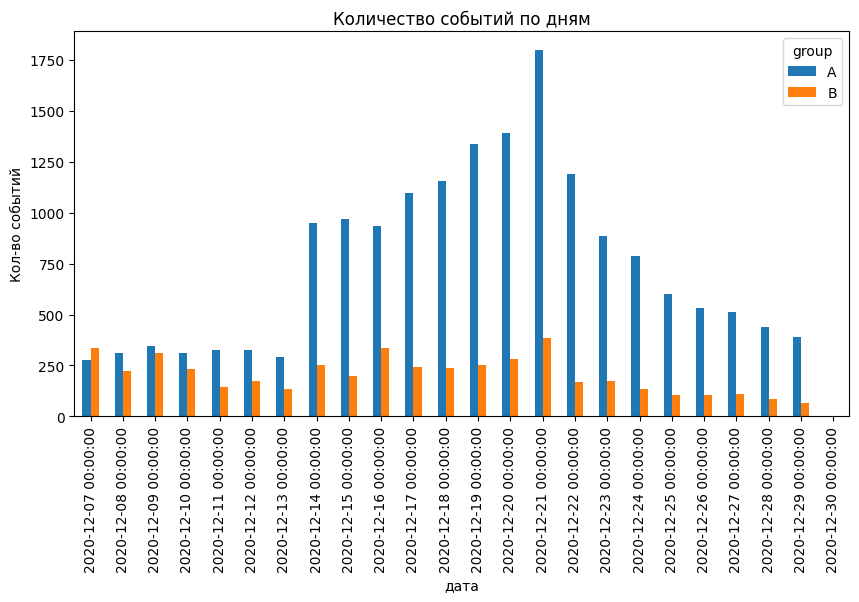

In [41]:
data_rst.pivot_table(index = 'event_date', columns = 'group', values = 'user_id', aggfunc = 'count').\
    plot(kind = 'bar', figsize = (10, 5), title = 'Количество событий по дням', ylabel = 'Кол-во событий',
        xlabel = 'дата');

**Выводы:**
1. В группе А мы видим сильный рост количества событий с 2020-12-14, после остановки набора пользователей в тест 2020-12-21 кол-во событий постепенно уменьшается
2. В группе В мы видим достаточно равномерное распределение количества событий по дням, после остановки набора пользователей в тест 2020-12-21 кол-во событий постепенно уменьшается

### Посмотрим на распределение кол-ва совершаемых пользователями событий в тестовых группах по дням:
1. кол-во регистраций
2. кол-во авторизаций
3. кол-во просмотров карточек товаров
4. кол-во просмотров корзины
5. кол-во покупок

#### Оценим кол-во регистраций пользователей по группам по дням

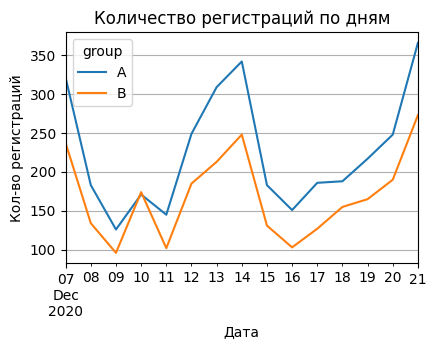

In [42]:
plt.figure(figsize=(10, 3))
plt.rcParams.update({'font.size': 10})

data_rst.pivot_table(index = 'first_date', columns = 'group', values = 'user_id', aggfunc = 'nunique').\
      plot(ax=plt.subplot(1, 2, 1), ylabel = "Кол-во регистраций", xlabel = 'Дата', fontsize=10, grid = True,\
           title = 'Количество регистраций по дням');

In [43]:
data_rst.groupby('event_name')['event_name'].count()

event_name
login           9901
product_cart    2886
product_page    6116
purchase        2939
Name: event_name, dtype: int64

In [44]:
data_rst.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24516 entries, 0 to 24515
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     24516 non-null  object        
 1   group       24516 non-null  object        
 2   ab_test     24516 non-null  object        
 3   first_date  24516 non-null  datetime64[ns]
 4   region      24516 non-null  object        
 5   device      24516 non-null  object        
 6   event_dt    21842 non-null  datetime64[ns]
 7   event_name  21842 non-null  object        
 8   details     2939 non-null   float64       
 9   event_date  21842 non-null  datetime64[ns]
 10  day_event   21842 non-null  float64       
dtypes: datetime64[ns](3), float64(2), object(6)
memory usage: 2.2+ MB


Подготовим таблицу с первыми событиями на каждого пользователя в группе А, группе B

In [45]:
data_events_A = data_rst.query('group == "A"').\
                pivot_table(index = 'user_id', columns = 'event_name', values = 'event_date',\
                aggfunc = 'min')
data_events_B = data_rst.query('group == "B"').\
                pivot_table(index = 'user_id', columns = 'event_name', values = 'event_date',\
                aggfunc = 'min')

#### Сравним кол-во регистраций и кол-во авторизаций по группам

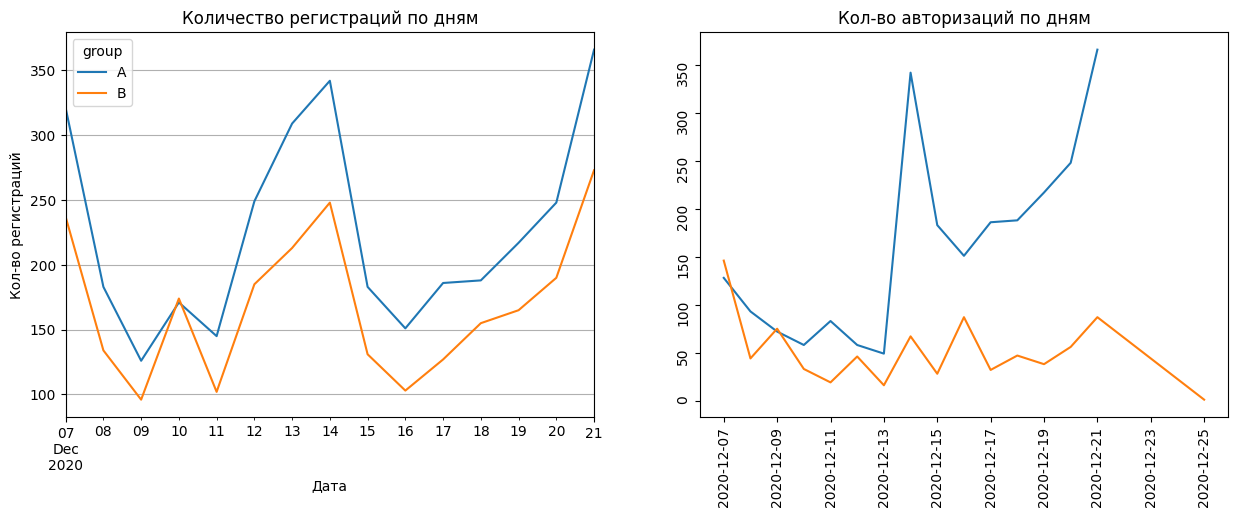

In [46]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize=(15, 5))

event_login_A = data_events_A.groupby(['login'])['login'].count()
axs[1].plot(event_login_A.index, event_login_A, label='A')

event_login_B = data_events_B.groupby(['login'])['login'].count()
axs[1].plot( event_login_B.index, event_login_B, label='B')

axs[1].set_title('Кол-во авторизаций по дням')
axs[1].tick_params(labelrotation=90)

data_rst.pivot_table(index = 'first_date', columns = 'group', values = 'user_id', aggfunc = 'nunique').\
      plot(ax=plt.subplot(1, 2, 1), ylabel = "Кол-во регистраций", xlabel = 'Дата', fontsize=10, grid = True,\
           title = 'Количество регистраций по дням');


#### Оценим кол-во просмотров карточек товаров по группам

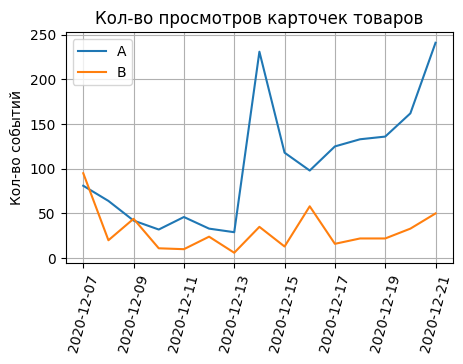

In [47]:
plt.figure(figsize=(5, 3))
event_login_A = data_events_A.groupby(['product_page'])['product_page'].count()
plt.plot(event_login_A.index, event_login_A, label='A')

event_login_B = data_events_B.groupby(['product_page'])['product_page'].count()
plt.plot(event_login_B.index, event_login_B, label='B')

plt.title('Кол-во просмотров карточек товаров')
plt.xticks(rotation=75)
plt.ylabel('Кол-во событий')
plt.grid(True)
plt.legend();

#### Оценим кол-во просмотров корзины товаров по группам

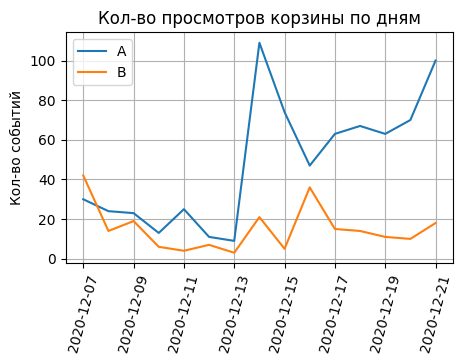

In [48]:
plt.figure(figsize=(5, 3))
event_login_A = data_events_A.groupby(['product_cart'])['product_cart'].count()
plt.plot(event_login_A.index, event_login_A, label='A')

event_login_B = data_events_B.groupby(['product_cart'])['product_cart'].count()
plt.plot(event_login_B.index, event_login_B, label='B')

plt.title('Кол-во просмотров корзины по дням')
plt.xticks(rotation=75)
plt.ylabel('Кол-во событий')
plt.grid(True)
plt.legend();

#### Оценим кол-во покупок товаров по группам

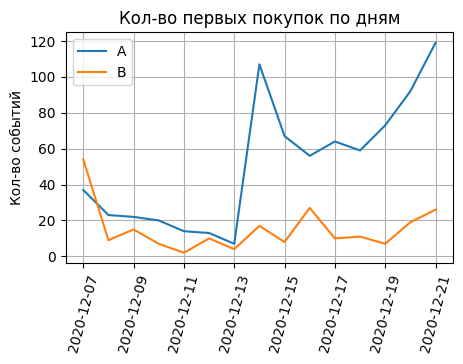

In [49]:
plt.figure(figsize=(5, 3))
event_login_A = data_events_A.groupby(['purchase'])['purchase'].count()
plt.plot(event_login_A.index, event_login_A, label='A')

event_login_B = data_events_B.groupby(['purchase'])['purchase'].count()
plt.plot(event_login_B.index, event_login_B, label='B')

plt.title('Кол-во первых покупок по дням')
plt.xticks(rotation=75)
plt.ylabel('Кол-во событий')
plt.grid(True)
plt.legend();


Посмотрим, на какой день пользователи совершают покупку в среднем и наиболее часто

In [50]:
data_rst.query('event_name == "purchase" and details > 0').groupby('group')['day_event'].describe().round()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,2359.0,3.0,4.0,0.0,0.0,2.0,5.0,22.0
B,580.0,4.0,5.0,0.0,0.0,1.0,5.0,22.0


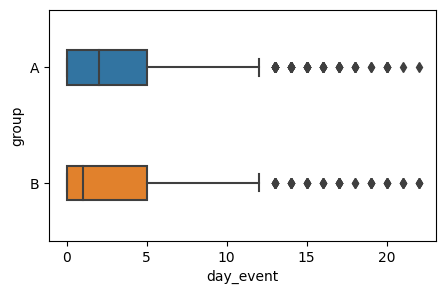

In [51]:
data_1 = data_rst.query('event_name == "purchase" and details > 0')[['group','day_event']]
plt.subplots(figsize=(5, 3))
sns.boxplot(data=data_1, x = 'day_event', y = 'group', width = 0.3);

**Выводы:**
1. В группе А начиная с 2020-12-13 мы видим повышение покупательской активности, в то время как в группе В каких-то явных изменений не наблюдается
2. Из графика *ящик с усами* мы видим, что и клиенты группы А, и клиенты группы В в большинстве совершают покупки до 5 дня, но в группе А чаще всего на 2 день, а в группе В на 1 день.

## Оценим ожидаемый эффект.  
За 14 дней с момента регистрации в системе пользователи ожидаемо покажут улучшение каждой метрики не менее, чем на 10%:
- конверсии в просмотр карточек товаров — событие product_page
- просмотры корзины — событие product_cart
- покупки — событие purchase

### Построим воронки по группам теста

In [52]:
funnel_group_A = data_events_A.count().reset_index()
funnel_group_A = funnel_group_A.reindex(index = [0, 2, 1, 3])
funnel_group_A.columns = ['funnel_stage', 'users_cnt']
funnel_group_A['users_%'] = (funnel_group_A['users_cnt']/funnel_group_A['users_cnt'].values[0]*100).round(1)
funnel_group_A

,funnel_stage,users_cnt,users_%
0,login,2422,100.0
2,product_page,1571,64.9
1,product_cart,728,30.1
3,purchase,773,31.9


In [53]:
funnel_group_B = data_events_B.count().reset_index()
funnel_group_B = funnel_group_B.reindex(index = [0, 2, 1, 3])
funnel_group_B.columns = ['funnel_stage', 'users_cnt']
funnel_group_B['users_%'] = (funnel_group_B['users_cnt']/funnel_group_B['users_cnt'].values[0]*100).round(1)
funnel_group_B

,funnel_stage,users_cnt,users_%
0,login,822,100.0
2,product_page,459,55.8
1,product_cart,225,27.4
3,purchase,226,27.5


Визуализируем воронки на 1 графике.  
Процент пользователей на всех этапах будем считать от события `login` - "авторизация"

In [54]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Группа А',
    y = funnel_group_A['funnel_stage'],
    x = funnel_group_A['users_cnt'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Группа В',
    #orientation = "h",
    y = funnel_group_B['funnel_stage'],
    x = funnel_group_B['users_cnt'],
    textposition = "inside",
    textinfo = "value+percent initial"))
fig.show()

Оценим разницу авторизованных пользователей по группам

In [55]:
(funnel_group_A['users_cnt'].values[0]/funnel_group_B['users_cnt'].values[0]).round(1)

2.9

**Вывод:**  
- количество пользователей, участвующих в воронке продаж, сильно отличается по группам - в 2.9 раз:
    * группа А - 2422 чел
    * группа В - 822 чел  
  
В то время, как изначально количество зарегистрированных пользователей в группах отличалось всего на 34% в пользу группы А
- в группе А на 2-й этап воронки - просмотр товаров - переходит на 9% больше пользователей, чем в группе В
- в группе А на 3-й этап воронки - формирование корзины товаров - переходит на 3% больше пользователей, чем в группе В от числа авторизованных
- в группе А на 4-й этап воронки - покупка товаров - переходит на 5% больше пользователей, чем в группе В от числа авторизованных
- мы видим, что в обеих группах процент пользователей, дошедших до покупки, немного превышает процент пользователей, сформировавших корзину - это говорит о том, что есть пользователи, которые пропускают данный этап

## Проверим статистическую разницу долей осуществления всех событий воронки продаж z-критерием.  
**Сформулируем гипотезы для каждого события:**  
1. **Но:** Доля авторизованных пользователей группы А, совершившая переход к просмотру карточки товара, не имеет статистически значимой разницы с долей авторизованных пользователей группы В, совершивших переход к просмотру карточки товара.  
    **Н1:** Доли авторизованных пользователей в группах  А и В, перешедших к просмотру  карточки товара, имеют статистически значимую разницу.
2.  **Но:** Доля авторизованных пользователей группы А, совершившая переход к просмотру продуктовой корзины, не имеет статистически значимой разницы с долей авторизованных пользователей группы В, совершивших переход к просмотру продуктовой корзины.  
    **Н1:** Доли авторизованных пользователей в группах  А и В, перешедших к просмотру продуктовой корзины, имеют статистически значимую разницу.
3. **Но:** Доля авторизованных пользователей группы А, совершившая переход к покупке товара, не имеет статистически значимой разницы с долей авторизованных пользователей группы В, совершивших переход к покупке товара.  
    **Н1:** Доли авторизованных пользователей в группах  А и В, перешедших к покупке товара, имеют статистически значимую разницу.
    
Примем уровень значимости alpha = 0.05 с поправкой Бонферрони для 3 тестов: поделим его на 3

In [56]:
alpha = 0.05/3
funnel_stage = ['product_page', 'product_cart', 'purchase']
for stage in funnel_stage:
    events = np.array([funnel_group_A.query('funnel_stage == @stage')['users_cnt'].sum(), \
                   funnel_group_B.query('funnel_stage == @stage')['users_cnt'].sum()])
    users = np.array([funnel_group_A.query('funnel_stage == "login"')['users_cnt'].sum(), \
                  funnel_group_B.query('funnel_stage == "login"')['users_cnt'].sum()])
    p1 = events[0]/users[0]
    p2 = events[1]/users[1]

    p_combined = sum(events)/sum(users)
    z_value = (p1-p2)/mth.sqrt(p_combined*(1-p_combined)*(1/events[0] + 1/events[1]))

    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Результат для события', stage,'\n', 'p-значение: ', p_value)
    print('Доля в группе А:', (p1*100).round(),'%; Доля в группе В:', (p2*100).round(),'%')
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница', end='\n\n')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными', end='\n\n')


Результат для события product_page 
 p-значение:  0.0004402946747179559
Доля в группе А: 65.0 %; Доля в группе В: 56.0 %
Отвергаем нулевую гипотезу: между долями есть значимая разница

Результат для события product_cart 
 p-значение:  0.43953861009604456
Доля в группе А: 30.0 %; Доля в группе В: 27.0 %
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат для события purchase 
 p-значение:  0.2052815061762343
Доля в группе А: 32.0 %; Доля в группе В: 27.0 %
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



## Выводы по результатам исследования:
1. Правила проведения А\В теста не соблюдены по следующим критериям:  
  - во время проведения А\В тестирования проводились маркетинговые акции, которые могли повлиять на результаты теста
  - во время проведения анализиуемого А\В теста `recommender_system_test` проводился конкурирующий тест `interface_eu_test`, который мог исказить результаты анализируемого теста
  - доля пользователей из Европы составила 13%  вместо 15% по тех.заданию
  - тест остановлен 2020-12-30 вместо 2021-01-04 по тех.заданию
2. В процессе анализа выявилась неравномерность распределения конверсии пользователей в анализируемых группах из регистрации в авторизацию, т.е. вхождения в воронку продаж.  В связи с этим изначальная разница в группах в 34% гр.А больше гр.В изменилась: по кол-ву авторизаций гр.А почти в 3 раза больше гр.B
3. Количество событий в группах существенно отличается как в абсолютном, так и в относительном выражении:
    - в группе А наблюдается существенный рост кол-ва событий с 2020-12-14, после остановки набора пользователей в тест 2020-12-21 кол-во событий постепенно уменьшается;  
    - в группе В мы видим достаточно равномерное распределение количества событий по дням, после остановки набора пользователей в тест 2020-12-21 кол-во событий постепенно уменьшается;
    - в группе А среднее кол-во событий на пользователя 5, в группе В - 2
4. И клиенты группы А, и клиенты группы В в большинстве совершают покупки до 5 дня, но в группе А чаще всего на 2 день, а в группе В на 1 день
5. Результаты z-теста, который оценивал только этапы прохождения воронки продаж:
- Результат для события product_page - просмотр карточки товара:
    **Отвергаем нулевую гипотезу: между долями в группах А и В есть значимая разница**
- Результат для события product_cart - просмотр корзины товаров:
    **Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в группах А и В разными**
- Результат для события purchase - покупка:  **Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли в группах А и В разными**
6. По результатам проведения А\B теста можно сделать вывод об ухудшении пользовательских метрик в группе В по сравнению с группой А. Нет никаких оснований предполагать, что изменения в экспериментальной группе хоть как-то улучшили конверсию на этапах прохождения пользователями воронки продаж.
7. Результаты теста мы засчитываем, т.к. несоответствия тех.заданию оказались несущественными и проведение нового теста в данном случае нецелесообразно, т.к. это повлечет за собой:
    - новые затраты на проведение
    - новые затраты на оценку результатов
8. Недостатки, влияющие на качество проведения А\В тестирования необходимо учесть в дальнейшем при проведении новых А\В тестов:
    - необходимо соблюдать сроки проведения теста в соответствии с тех.заданием
    - нежелательно проводить А\В тесты в предпраздничные, праздничные дни, периоды естественного повышения спроса
    - необходимо договариваться с другими сотрудниками о проведении разных А\В тестов изолированно, чтобы результаты одного теста не влияли на результаты другого
    - по возможности нужно избегать пересечения А\В тестов с маркетинговыми акциями